In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Read the data

In [2]:
original_data = pd.read_csv("../day.csv")
original_data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [3]:
# see information
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


# Data cleaning

In [4]:
# as we don't have any missing values we can directly proceed with original dataset for visualisation
# let's drop instant column as it does not have any significance
# drop casual and registered columns as well, as those are similar as cnt just represent different categories
data = original_data.drop(["instant", "casual", "registered", "dteday"], axis=1)
data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600


# Visualise the data

<Figure size 1000x800 with 0 Axes>

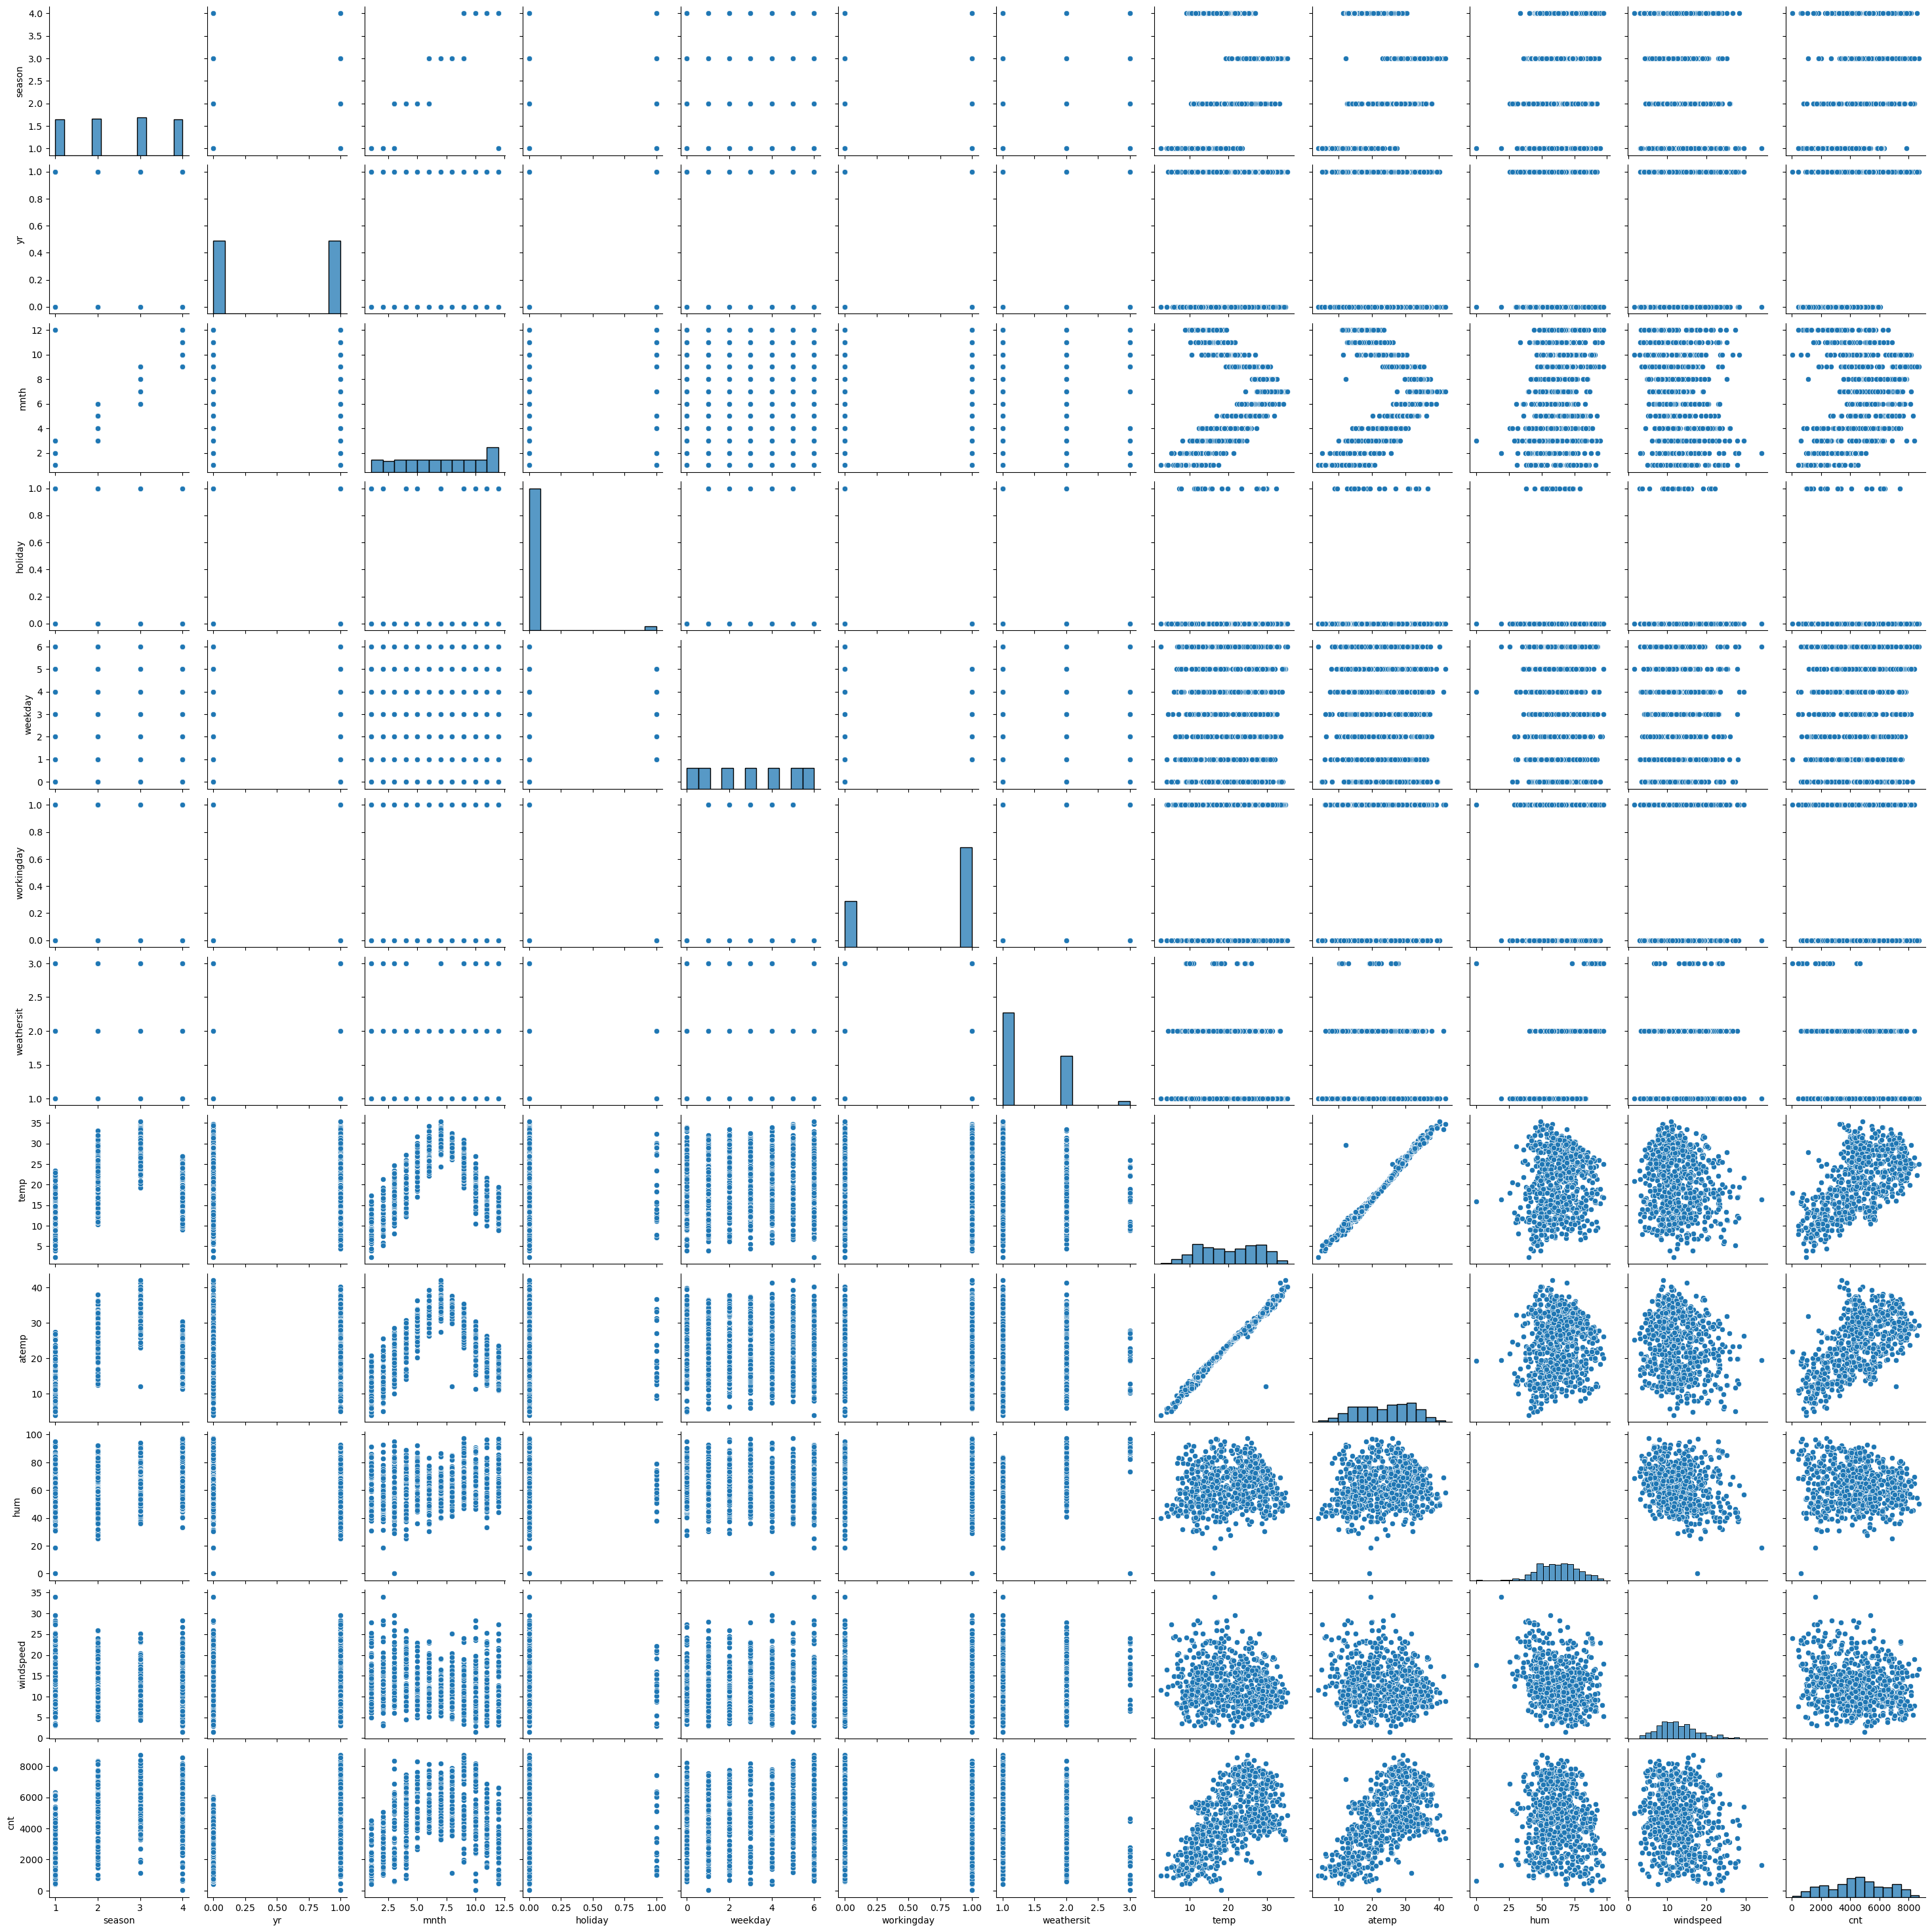

In [5]:
# let's first visualise the numeric variables to see relation of target variable with other variables

fig = plt.figure(figsize=(10,8))
sns.pairplot(data)
plt.show()

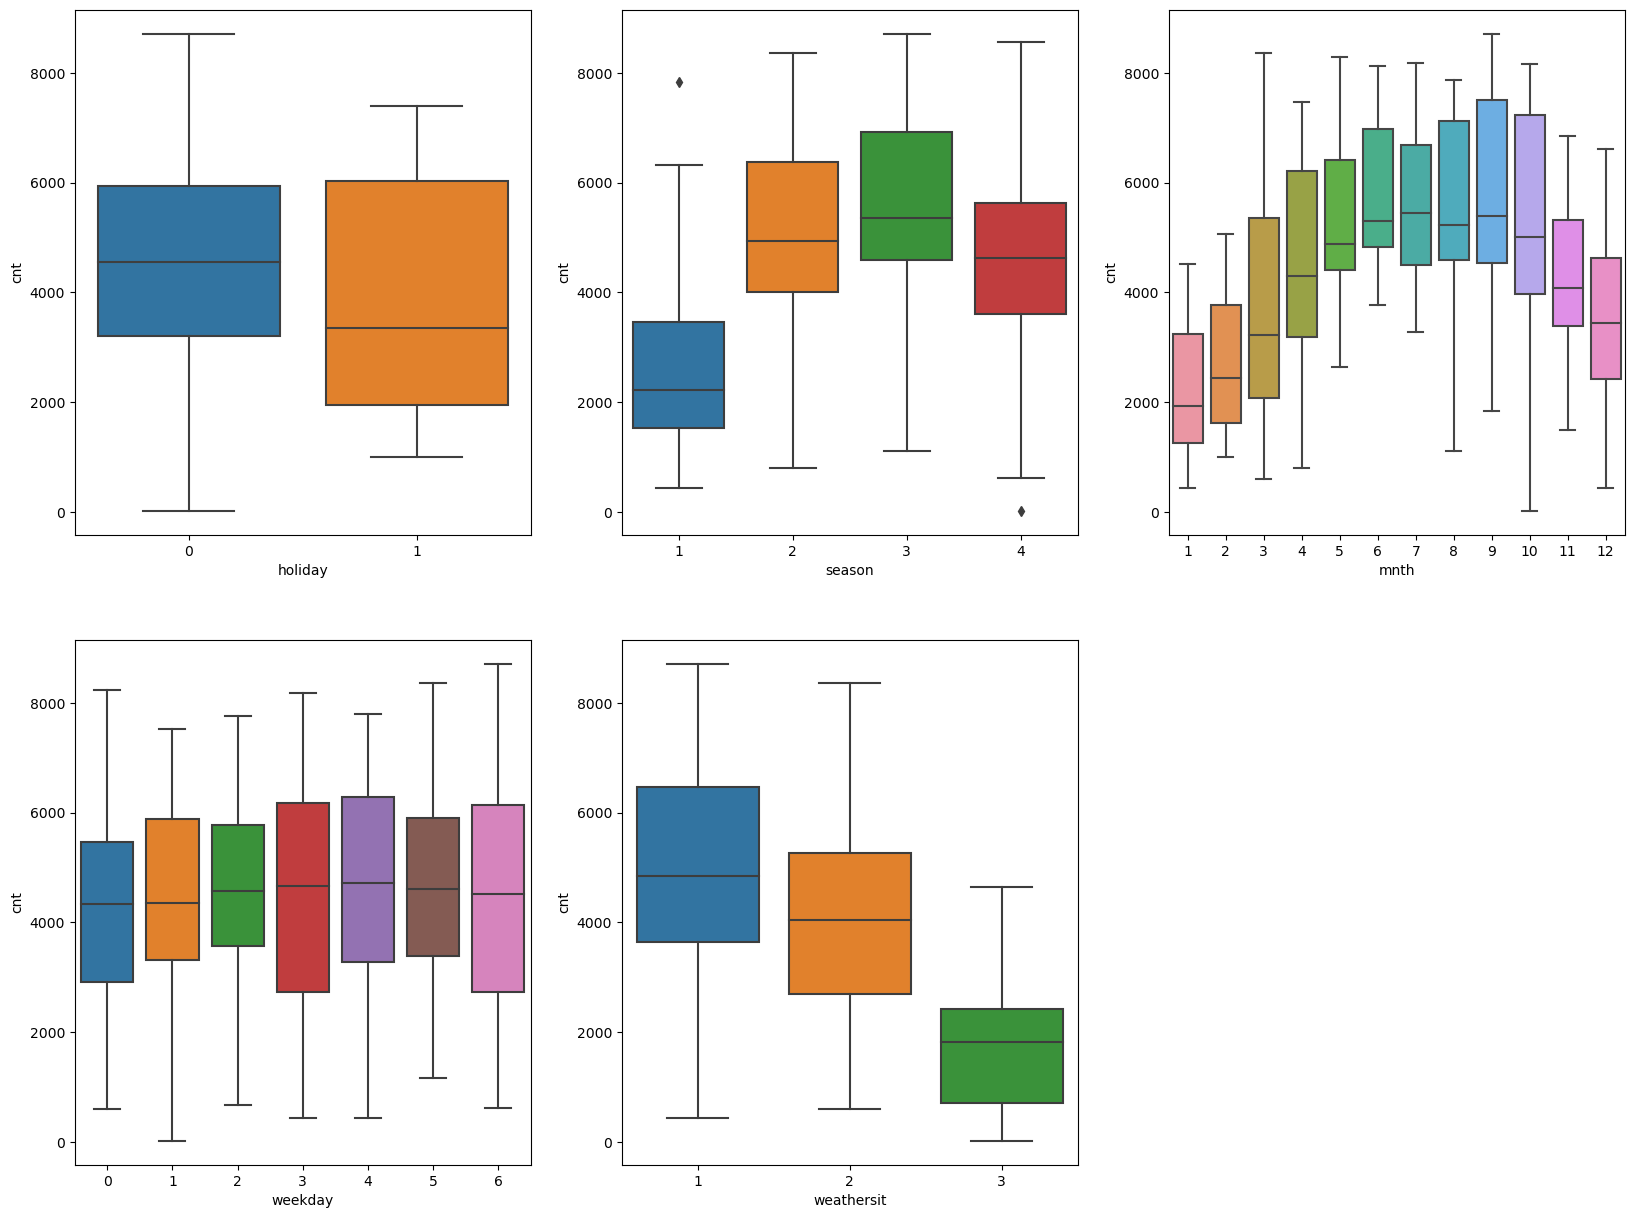

In [6]:
# visualise categorical variables

plt.figure(figsize=(20,15))
plt.subplot(2,3,1)
sns.boxplot(data=data, x="holiday", y="cnt")
plt.subplot(2,3,2)
sns.boxplot(data=data, x="season", y="cnt")
plt.subplot(2,3,3)
sns.boxplot(data=data, x="mnth", y="cnt")
plt.subplot(2,3,4)
sns.boxplot(data=data, x="weekday", y="cnt")
plt.subplot(2,3,5)
sns.boxplot(data=data, x="weathersit", y="cnt")
plt.show()

## Split the data

In [7]:
df_train, df_test = train_test_split(data, train_size=0.7, random_state=100)
print(df_train.shape)
print(df_test.shape)

(510, 12)
(220, 12)


# Rescale the numeric variables

In [8]:
scaler = MinMaxScaler()

numeric_var = ["temp", "atemp", "hum", "windspeed", "cnt"]

df_train[numeric_var] = scaler.fit_transform(df_train[numeric_var])

df_train.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
576,3,1,7,0,2,1,1,0.815169,0.766351,0.725633,0.264686,0.827658
426,1,1,3,0,6,0,2,0.442393,0.438975,0.640189,0.255342,0.465255
728,1,1,12,0,0,0,1,0.245101,0.200348,0.498067,0.663106,0.204096
482,2,1,4,0,6,0,2,0.395666,0.391735,0.504508,0.188475,0.482973
111,2,0,4,0,5,1,2,0.345824,0.318819,0.751824,0.380981,0.191095


In [9]:
df_train.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,2.513725,0.507843,6.541176,0.025490,2.990196,0.676471,1.403922,0.537440,0.513156,0.650480,0.320883,0.513499
std,1.110235,0.500429,3.465416,0.157763,2.017093,0.468282,0.547888,0.225858,0.212410,0.145846,0.169803,0.224421
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,3.000000,0.000000,1.000000,0.000000,1.000000,0.339853,0.332086,0.538643,0.199179,0.356420
50%,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.542596,0.529718,0.653714,0.296763,0.518638
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.735215,0.688457,0.754830,0.414447,0.684710
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Train the model

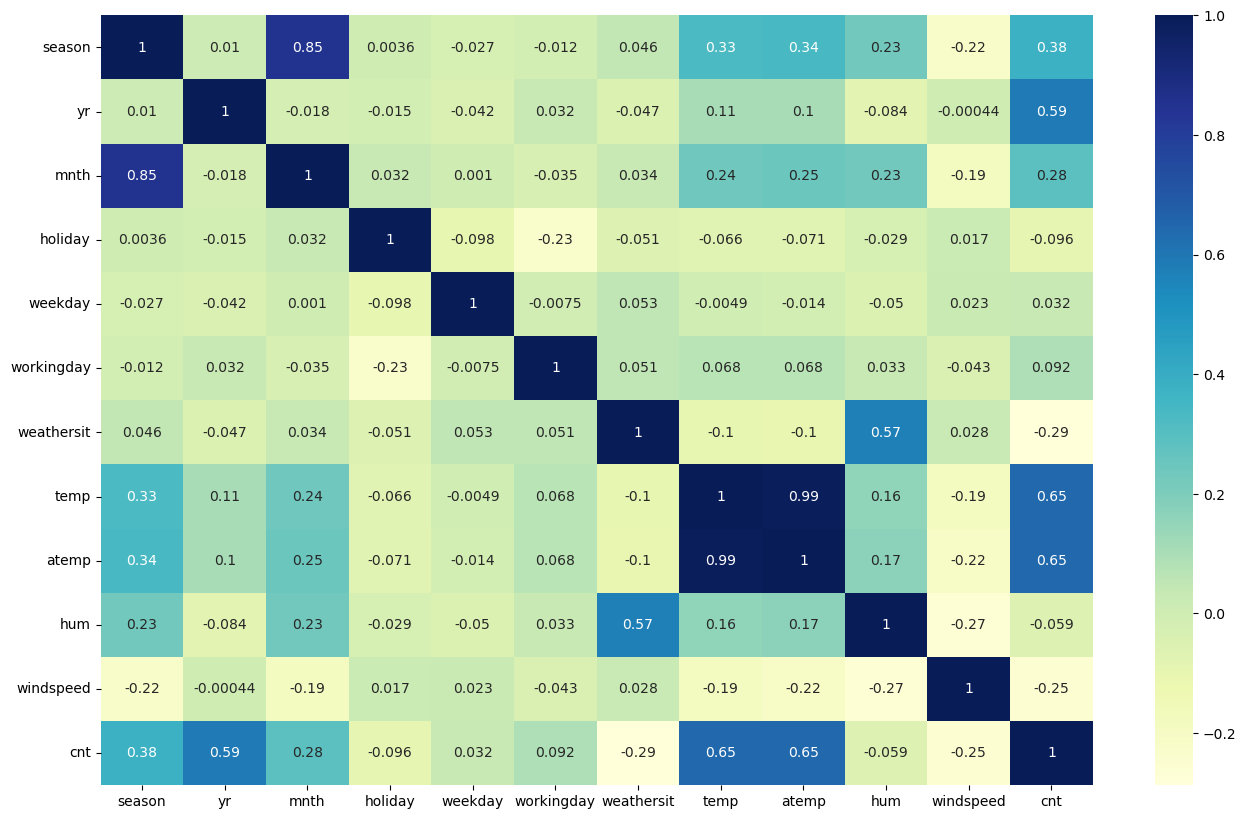

In [10]:
plt.figure(figsize=(16, 10))
sns.heatmap(df_train.corr(), annot=True, cmap="YlGnBu")
plt.show()

In [11]:
y_train = df_train.pop("cnt")
X_train = df_train

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 510 entries, 576 to 520
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      510 non-null    int64  
 1   yr          510 non-null    int64  
 2   mnth        510 non-null    int64  
 3   holiday     510 non-null    int64  
 4   weekday     510 non-null    int64  
 5   workingday  510 non-null    int64  
 6   weathersit  510 non-null    int64  
 7   temp        510 non-null    float64
 8   atemp       510 non-null    float64
 9   hum         510 non-null    float64
 10  windspeed   510 non-null    float64
dtypes: float64(4), int64(7)
memory usage: 47.8 KB


In [13]:
# add a constant
X_train_sm = sm.add_constant(X_train)

# create model
lr = sm.OLS(y_train, X_train_sm)

# fit
lr_model = lr.fit()

# params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     185.7
Date:                Sat, 05 Aug 2023   Prob (F-statistic):          2.86e-168
Time:                        19:36:11   Log-Likelihood:                 454.40
No. Observations:                 510   AIC:                            -884.8
Df Residuals:                     498   BIC:                            -834.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2153      0.030      7.167      0.000       0.156       0.274
season         0.0470      0.008      5.901      0.000       0.031       0.063
yr             0.2349      0.009     26.035      0.000       0.217       0.253
mnth          -0.0014      0.002     -0.570      0.569      -0.006       0.003
holiday       -0.0686      0.029     -2.341      0.020      -0.126      -0.011
weekday        0.0079      0.002      3.516      0.000       0.003       0.012
workingday     0.0194      0.010      1.974      0.049    9.27e-05       0.039
weathersit    -0.0790      0.010     -7.530      0.000      -0.100      -0.058
temp           0.2136      0.140      1.531      0.127      -0.061       0.488
atemp          0.2828      0.150      1.889      0.059      -0.011       0.577
hum           -0.0972      0.042     -2.341      0.020      -0.179      -0.016
windspeed     -0.1575      0.029     -5.477      0.000      -0.214      -0.101
==============================================================================
Omnibus:                       62.779   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              143.597
Skew:                          -0.662   Prob(JB):                     6.58e-32
Kurtosis:                       5.237   Cond. No.                         394.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
8,atemp,345.569854
7,temp,332.655059
9,hum,24.928116
0,season,23.678839
2,mnth,17.067177
6,weathersit,12.574466
10,windspeed,3.791065
5,workingday,3.138945
4,weekday,3.039610
1,yr,2.012787


In [15]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [16]:
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)
rfe = rfe.fit(X_train, y_train)

In [17]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('season', False, 4),
 ('yr', True, 1),
 ('mnth', False, 7),
 ('holiday', False, 2),
 ('weekday', False, 6),
 ('workingday', False, 5),
 ('weathersit', True, 1),
 ('temp', True, 1),
 ('atemp', True, 1),
 ('hum', False, 3),
 ('windspeed', True, 1)]

In [18]:
# as both the model results suggest mnth has lowest significance, let's remove that

X = X_train.drop(['mnth', 'season', 'holiday', 'weekday', 'workingday', 'hum'], axis=1)

In [19]:
# add a constant
X_train_sm = sm.add_constant(X)

# create model
lr = sm.OLS(y_train, X_train_sm)

# fit
lr_model = lr.fit()

# params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     311.7
Date:                Sat, 05 Aug 2023   Prob (F-statistic):          1.21e-151
Time:                        19:36:11   Log-Likelihood:                 398.23
No. Observations:                 510   AIC:                            -784.5
Df Residuals:                     504   BIC:                            -759.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2757      0.023     11.959      0.000       0.230       0.321
yr             0.2348      0.010     23.621      0.000       0.215       0.254
weathersit    -0.0835      0.009     -9.201      0.000      -0.101      -0.066
temp           0.2498      0.154      1.619      0.106      -0.053       0.553
atemp          0.3108      0.165      1.884      0.060      -0.013       0.635
windspeed     -0.1808      0.030     -5.967      0.000      -0.240      -0.121
==============================================================================
Omnibus:                       18.599   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.806
Skew:                          -0.368   Prob(JB):                     1.12e-05
Kurtosis:                       3.728   Cond. No.                         92.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
3,atemp,328.707565
2,temp,327.077430
1,weathersit,4.835504
4,windspeed,3.550174
0,yr,1.994833


In [21]:
# let's drop a temp as well. However, temp and atemp are highly correlated

X = X_train.drop(['mnth', 'season', 'holiday', 'weekday', 'workingday', 'hum', 'temp'], axis=1)

In [22]:
# add a constant
X_train_sm = sm.add_constant(X)

# create model
lr = sm.OLS(y_train, X_train_sm)

# fit
lr_model = lr.fit()

# params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     387.7
Date:                Sat, 05 Aug 2023   Prob (F-statistic):          2.13e-152
Time:                        19:36:11   Log-Likelihood:                 396.90
No. Observations:                 510   AIC:                            -783.8
Df Residuals:                     505   BIC:                            -762.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2713      0.023     11.831      0.000       0.226       0.316
yr             0.2353      0.010     23.632      0.000       0.216       0.255
weathersit    -0.0835      0.009     -9.184      0.000      -0.101      -0.066
atemp          0.5750      0.024     23.856      0.000       0.528       0.622
windspeed     -0.1720      0.030     -5.760      0.000      -0.231      -0.113
==============================================================================
Omnibus:                       20.844   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.213
Skew:                          -0.365   Prob(JB):                     7.48e-07
Kurtosis:                       3.892   Cond. No.                         14.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
1,weathersit,4.796188
2,atemp,4.153257
3,windspeed,3.480664
0,yr,1.994794


# Residual analysis

In [24]:
y_train_pred = lr_model.predict(X_train_sm)

D:\tools\anacoda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


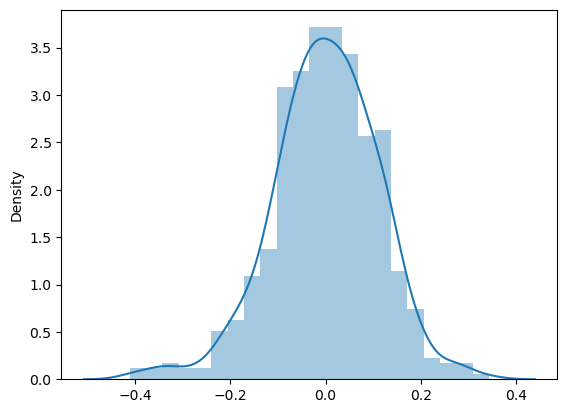

In [25]:
res = y_train - y_train_pred
sns.distplot(res)
plt.show()

In [26]:
# mean value is residing near zero and we see that the shape is normally distributed

# Predictions and evaluations

In [27]:
numeric_var = ["temp", "atemp", "hum", "windspeed", "cnt"]

df_test[numeric_var] = scaler.transform(df_test[numeric_var])

df_test.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
184,3,0,7,1,1,0,2,0.831783,0.769660,0.657364,0.084219,0.692706
535,2,1,6,0,3,1,1,0.901354,0.842587,0.610133,0.153728,0.712034
299,4,0,10,0,4,1,2,0.511964,0.496145,0.837699,0.334206,0.303382
221,3,0,8,0,3,1,1,0.881625,0.795343,0.437098,0.339570,0.547400
152,2,0,6,0,4,1,1,0.817246,0.741471,0.314298,0.537414,0.569029


In [28]:
y_test = df_test.pop('cnt')
X_test = df_test

In [29]:
# add constant

X_test_sm = sm.add_constant(X_test)
X_test_sm.head()

,const,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
184,1.0,3,0,7,1,1,0,2,0.831783,0.769660,0.657364,0.084219
535,1.0,2,1,6,0,3,1,1,0.901354,0.842587,0.610133,0.153728
299,1.0,4,0,10,0,4,1,2,0.511964,0.496145,0.837699,0.334206
221,1.0,3,0,8,0,3,1,1,0.881625,0.795343,0.437098,0.339570
152,1.0,2,0,6,0,4,1,1,0.817246,0.741471,0.314298,0.537414


In [30]:
X_test_sm = X_test_sm.drop(["season", "mnth", "holiday", "weekday", "workingday", "temp", "hum"],axis=1)
X_test_sm.head()

,const,yr,weathersit,atemp,windspeed
184,1.0,0,2,0.769660,0.084219
535,1.0,1,1,0.842587,0.153728
299,1.0,0,2,0.496145,0.334206
221,1.0,0,1,0.795343,0.339570
152,1.0,0,1,0.741471,0.537414


In [31]:
y_test_pred = lr_model.predict(X_test_sm)

In [32]:
r2_score(y_true=y_test, y_pred=y_test_pred)

0.7122597049173245